## 1. Graph Dataset

In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
from sklearn.preprocessing import StandardScaler, RobustScaler

class AirQualityGraphDataset:
    def __init__(
        self, 
        data_path: str,
        window_size: int = 24,  # 24 hours as default window size
        connection_radius: float = 50.0,  # default radius in kilometers (reduced from 1000km)
        normalize: bool = True,
        use_robust_scaler: bool = True,  # Use RobustScaler for PM2.5 values
        min_samples: int = 5  # Minimum number of samples per station
    ):
        """
        Create a graph dataset from air quality data.
        
        Args:
            data_path: Path to the CSV file containing air quality data
            window_size: Number of time steps to include in each node's features
            connection_radius: Maximum distance between nodes to create an edge (in km)
            normalize: Whether to normalize the PM2.5 values
            use_robust_scaler: Whether to use RobustScaler instead of StandardScaler
            min_samples: Minimum number of samples per station
        """
        self.window_size = window_size
        self.connection_radius = connection_radius
        self.normalize = normalize
        self.use_robust_scaler = use_robust_scaler
        self.min_samples = min_samples
        
        # Load and preprocess data
        self.raw_data = pd.read_csv(data_path)
        self.raw_data['datetime'] = pd.to_datetime(self.raw_data['datetime'])
        
        # Filter stations with too few samples
        station_counts = self.raw_data.groupby('station_loc').size()
        valid_stations = station_counts[station_counts >= self.min_samples].index
        self.raw_data = self.raw_data[self.raw_data['station_loc'].isin(valid_stations)]
        
        self.stations = self._extract_unique_stations()
        
        # Create graphs
        self.scalers = {}  # Store scalers for each station
        self.graphs = self._create_graphs()
    
    def _extract_unique_stations(self) -> Dict:
        """Extract unique monitoring stations from the dataset."""
        stations = {}
        for _, row in self.raw_data.drop_duplicates(['station_loc', 'latitude', 'longitude']).iterrows():
            station_id = row['station_loc']
            stations[station_id] = {
                'latitude': row['latitude'],
                'longitude': row['longitude'],
                'city': row['city']
            }
        
        print(f"Found {len(stations)} unique monitoring stations")
        return stations
    
    def _create_distance_matrix(self) -> np.ndarray:
        """Create a distance matrix between all stations."""
        n_stations = len(self.stations)
        distance_matrix = np.zeros((n_stations, n_stations))
        
        station_ids = list(self.stations.keys())
        
        for i in range(n_stations):
            for j in range(i + 1, n_stations):
                station_i = self.stations[station_ids[i]]
                station_j = self.stations[station_ids[j]]
                
                coord_i = (station_i['latitude'], station_i['longitude'])
                coord_j = (station_j['latitude'], station_j['longitude'])
                distance = geodesic(coord_i, coord_j).kilometers

                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance
                
        return distance_matrix
    
    def _create_adjacency_matrix(self, distance_matrix: np.ndarray) -> np.ndarray:
        """Create an adjacency matrix based on the distance matrix and connection radius."""
        adj_matrix = (distance_matrix <= self.connection_radius).astype(float)
        
        np.fill_diagonal(adj_matrix, 1.0)
        
        # Create distance-weighted edges
        # Closer stations have higher weights
        edge_indices = np.where((adj_matrix > 0) & (distance_matrix > 0))
        for i, j in zip(edge_indices[0], edge_indices[1]):
            if i != j: 
                # Use inverse distance weighting (closer = higher weight)
                adj_matrix[i, j] = 1.0 / (1.0 + distance_matrix[i, j]/10)
        
        return adj_matrix
    
    def _create_edge_index_and_attr(self, adj_matrix: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """Create edge_index and edge_attr from adjacency matrix."""
        edges = np.where(adj_matrix > 0)
        edge_index = torch.tensor(np.vstack(edges), dtype=torch.long)
        edge_attr = torch.tensor(adj_matrix[edges], dtype=torch.float).view(-1, 1)
        
        return edge_index, edge_attr
    
    def _get_station_time_series(self) -> Dict[str, np.ndarray]:
        """Extract time series for each station."""
        station_series = {}
        for station_id in self.stations.keys():
            station_data = self.raw_data[self.raw_data['station_loc'] == station_id]
            station_data = station_data.sort_values('datetime')
            pm25_series = station_data['PM25'].values
            
            # Handle missing values
            if np.isnan(pm25_series).any():
                # Linear interpolation for NaN values
                nan_indices = np.where(np.isnan(pm25_series))[0]
                valid_indices = np.where(~np.isnan(pm25_series))[0]
                if len(valid_indices) > 0:  # If there are any valid values
                    for idx in nan_indices:
                        # Find nearest valid points
                        left_valid = valid_indices[valid_indices < idx]
                        right_valid = valid_indices[valid_indices > idx]
                        
                        if len(left_valid) > 0 and len(right_valid) > 0:
                            # Interpolate between valid points
                            left_idx = left_valid[-1]
                            right_idx = right_valid[0]
                            left_val = pm25_series[left_idx]
                            right_val = pm25_series[right_idx]
                            weight = (idx - left_idx) / (right_idx - left_idx)
                            pm25_series[idx] = left_val + weight * (right_val - left_val)
                        elif len(left_valid) > 0:
                            pm25_series[idx] = pm25_series[left_valid[-1]]
                        elif len(right_valid) > 0:
                            pm25_series[idx] = pm25_series[right_valid[0]]
            
            if self.normalize:
                if self.use_robust_scaler:
                    scaler = RobustScaler()
                else:
                    scaler = StandardScaler()
                
                # Reshape for scaler
                pm25_series = pm25_series.reshape(-1, 1)
                pm25_series = scaler.fit_transform(pm25_series).flatten()
                self.scalers[station_id] = scaler
            
            station_series[station_id] = pm25_series
        
        return station_series
    
    def _create_node_features(self, station_series: Dict[str, np.ndarray]) -> List[torch.Tensor]:
        """Create node features as sliding windows of time series."""
        all_features = []
        
        for station_id, series in station_series.items():
            features = []
            for i in range(len(series) - self.window_size + 1):
                window = series[i:i+self.window_size]
                features.append(torch.tensor(window, dtype=torch.float))
            
            if features:
                # Stack all windows for this station
                station_features = torch.stack(features)
                all_features.append(station_features)
        
        return all_features
    
    def _create_graphs(self) -> List[Data]:
        """Create PyTorch Geometric graph objects."""
        distance_matrix = self._create_distance_matrix()
        adj_matrix = self._create_adjacency_matrix(distance_matrix)
        edge_index, edge_attr = self._create_edge_index_and_attr(adj_matrix)
        
        station_series = self._get_station_time_series()
        node_features_by_station = self._create_node_features(station_series)
        
        min_windows = min(len(features) for features in node_features_by_station) if node_features_by_station else 0
        if min_windows == 0:
            raise ValueError("No valid time windows found for stations")
            
        node_features_by_station = [features[:min_windows] for features in node_features_by_station]
        
        self.station_to_idx = {station_id: idx for idx, station_id in enumerate(self.stations.keys())}
        
        # Create a graph for each time window
        graphs = []
        for time_idx in range(min_windows):
            try:
                x = torch.stack([station_features[time_idx] for station_features in node_features_by_station])
                station_ids = list(self.stations.keys())
                # Create graph
                graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
                graph.station_ids = station_ids
                graphs.append(graph)
            except Exception as e:
                print(f"Error creating graph at time index {time_idx}: {e}")
                continue
        
        print(f"Created {len(graphs)} valid graphs")
        return graphs
    
    def plot_graph(self, index: int = 0):
        """Plot the graph structure with node positions based on lat/lon."""
        
        graph = self.graphs[index]
        
        plt.figure(figsize=(10, 8))
        
        # Extract station coordinates
        station_ids = list(self.stations.keys())
        positions = np.array([[self.stations[id]['latitude'], self.stations[id]['longitude']] for id in station_ids])
        
        #plotting nodes and edges
        plt.scatter(positions[:, 1], positions[:, 0], s=100, c='blue', label='Stations')
    
        for i, j in graph.edge_index.t().tolist():
            if i != j: 
                plt.plot([positions[i, 1], positions[j, 1]], [positions[i, 0], positions[j, 0]], 'k-', alpha=0.3)
        
        for i, station_id in enumerate(station_ids):
            plt.annotate(station_id, (positions[i, 1], positions[i, 0]), fontsize=8)
        
        plt.title(f"Air Quality Monitoring Stations Graph")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()
        plt.savefig("graph_structure.png")
        plt.show()
        plt.close()
        
    def __len__(self) -> int:
        """Return the number of graphs."""
        return len(self.graphs)
    
    def __getitem__(self, idx: int) -> Data:
        """Get a graph by index."""
        return self.graphs[idx]

## 2. Graph Convolutional Network Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GCN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        output_dim: int = 32,
        dropout: float = 0.2,
        n_layers: int = 3
    ):
        """
        Graph Convolutional Network for generating node embeddings.
        
        Args:
            input_dim: Input feature dimension
            hidden_dim: Hidden layer dimension
            output_dim: Output embedding dimension
            dropout: Dropout rate
            n_layers: Number of GCN layers
        """
        super(GCN, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        self.conv_layers.append(GCNConv(input_dim, hidden_dim))
        self.batch_norms.append(BatchNorm(hidden_dim))
        
        for _ in range(n_layers - 2):
            self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))
            self.batch_norms.append(BatchNorm(hidden_dim))
        
        self.conv_layers.append(GCNConv(hidden_dim, output_dim))

        self.node_transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        
        # Decoder with more capacity
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim)
        )
        
        self.dropout = dropout
    
    def forward(self, data):
        """
        Forward pass through the GNN.
        
        Args:
            data: PyTorch Geometric Data object
            
        Returns:
            node_embeddings: Embeddings for each node
            graph_embedding: Embedding for the entire graph
        """
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr.squeeze()

        node_features = self.node_transform(x)

        for i, (conv, bn) in enumerate(zip(self.conv_layers[:-1], self.batch_norms)):
            x_conv = conv(x, edge_index, edge_weight)
            x_conv = bn(x_conv)
            x_conv = F.relu(x_conv)
            
            # Add residual connection if dimensions match
            if x.size(1) == x_conv.size(1):
                x = x_conv + x
            else:
                x = x_conv

            if i == 0:
                x = x + node_features
                
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv_layers[-1](x, edge_index, edge_weight)

        node_embeddings = x

        graph_embedding = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long, device=x.device))
        
        return node_embeddings, graph_embedding
    
    def decode(self, embeddings):
        return self.decoder(embeddings)

## 3. GNN Training Function

In [3]:
import os
import torch
import numpy as np
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

def train_gnn(
    data_path: str,
    output_dir: str,
    window_size: int = 24,
    hidden_dim: int = 128,
    output_dim: int = 64,
    batch_size: int = 32,
    epochs: int = 100,
    lr: float = 0.001,
    weight_decay: float = 5e-4,
    patience: int = 10,
    min_delta: float = 0.001,
):
    """
    Train a GNN on air quality data and save node embeddings.
    
    Args:
        data_path: Path to the air quality data CSV
        output_dir: Directory to save embeddings
        window_size: Size of time window for node features
        hidden_dim: Hidden dimension for GNN
        output_dim: Output embedding dimension
        batch_size: Batch size for training
        epochs: Number of training epochs
        lr: Learning rate
        weight_decay: L2 regularization
        patience: Early stopping patience
        min_delta: Minimum change to qualify as improvement
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Create dataset
    dataset = AirQualityGraphDataset(
        data_path=data_path,
        window_size=window_size,
        normalize=True
    )
    
    # Split into train/val/test
    n_samples = len(dataset)
    train_size = int(0.7 * n_samples)
    val_size = int(0.15 * n_samples)
    test_size = n_samples - train_size - val_size
    
    # for better generalization
    indices = torch.randperm(n_samples).tolist()
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_dataset = [dataset[i] for i in train_indices]
    val_dataset = [dataset[i] for i in val_indices]
    test_dataset = [dataset[i] for i in test_indices]
    
    # data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    input_dim = dataset[0].x.size(1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(
        input_dim=input_dim, 
        hidden_dim=hidden_dim, 
        output_dim=output_dim, 
        dropout=0.2, 
        n_layers=4
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    all_train_losses = []
    all_val_losses = []
    
    print(f"Starting training for {epochs} epochs...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            node_emb, graph_emb = model(data)
            x_reconstructed = model.decode(node_emb)
            # Compute loss
            mse_loss = F.mse_loss(x_reconstructed, data.x)
            l1_reg = 0.001 * torch.norm(node_emb, p=1)
            loss = mse_loss + l1_reg
            
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += mse_loss.item()
            
        train_loss /= len(train_loader)
        all_train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                node_emb, graph_emb = model(data)
                x_reconstructed = model.decode(node_emb)
                loss = F.mse_loss(x_reconstructed, data.x)
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        all_val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(output_dir, "best_gnn_model.pt"))
            print(f"New best model saved with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement, patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(all_train_losses, label='Train Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(os.path.join(output_dir, 'loss_curves.png'))
    
    model.load_state_dict(torch.load(os.path.join(output_dir, "best_gnn_model.pt")))
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            node_emb, graph_emb = model(data)
            x_reconstructed = model.decode(node_emb)
            loss = F.mse_loss(x_reconstructed, data.x)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    print(f"Final test loss: {test_loss:.4f}")
    
    model.eval()
    all_embeddings = []
    all_stations = []
    all_timestamps = []
    timestamp_counter = 0
    
    print(f"Dataset size: {len(dataset)} graphs")
    
    station_embeddings = {}
    
    with torch.no_grad():
        for time_idx, data in enumerate(DataLoader(dataset, batch_size=1)):
            data = data.to(device)
            node_emb, _ = model(data)
            
            # Process each node (station) separately to maintain identity
            for i, station_id in enumerate(data.station_ids[0]):
                if station_id not in station_embeddings:
                    station_embeddings[station_id] = {}
                    
                # Store embedding for this station at this timestamp
                station_embeddings[station_id][time_idx] = node_emb[i].cpu().numpy()
                
                all_embeddings.append(node_emb[i].cpu().numpy())
                all_stations.append(station_id)
                all_timestamps.append(time_idx)
    
    # Create structured embeddings with mapping
    embeddings_data = {
        'embedding': all_embeddings,
        'station_id': all_stations,
        'timestamp_idx': all_timestamps,
        'station_embeddings': station_embeddings
    }
    np.save(os.path.join(output_dir, "structured_embeddings.npy"), embeddings_data)
    
    model_file = os.path.join(output_dir, "gnn_model.pt")
    torch.save(model.state_dict(), model_file)
    print(f"Model saved to {model_file}")
    
    return model, embeddings_data

## 4. Main Execution Code

In [4]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def main():

    data_path = "/code/GCNTFT/data/processed/gnn_ready.csv"
    output_dir = f"/code/GCNTFT/data/embeddings_v2_final_{datetime.datetime.now().strftime('%Y%m%d%H%M')}"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print("Creating graph dataset...")
    dataset = AirQualityGraphDataset(
        data_path=data_path,
        window_size=24,
        connection_radius=30.0,
        normalize=True,
        use_robust_scaler=True
    )
    
    print("Plotting graph structure...")
    dataset.plot_graph()

    print("Training GNN and generating embeddings...")
    model, embeddings_data = train_gnn(
        data_path=data_path,
        output_dir=output_dir,
        window_size=24,  
        hidden_dim=256,  
        output_dim=32,   
        batch_size=32,   
        epochs=200,      
        lr=0.0003,       
        weight_decay=1e-4, 
        patience=15,    
        min_delta=0.0001 
    )
    
    # Load embeddings
    structured_embeddings_file = os.path.join(output_dir, "structured_embeddings.npy")
    if os.path.exists(structured_embeddings_file):
        embeddings_data = np.load(structured_embeddings_file, allow_pickle=True).item()
        
        # Create DataFrame with station and timestamp information
        embedding_arrays = [arr for arr in embeddings_data['embedding']]
        embedding_arrays_np = np.array(embedding_arrays)
        
        embedding_df = pd.DataFrame(
            embedding_arrays,
            columns=[f"emb_{i}" for i in range(len(embedding_arrays[0]))]
        )
        
        embedding_df['station_id'] = embeddings_data['station_id']
        embedding_df['timestamp_idx'] = embeddings_data['timestamp_idx']

        raw_data = pd.read_csv(data_path)
        raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])
        
        # Map timestamp indices to actual timestamps
        all_timestamps = sorted(raw_data['datetime'].unique())
        valid_timestamps = all_timestamps[23:]
        
        embedding_df['datetime'] = embedding_df['timestamp_idx'].apply(
            lambda idx: valid_timestamps[idx] if idx < len(valid_timestamps) else None
        )
        
        # Set multi-index
        embedding_df = embedding_df.set_index(['datetime', 'station_id']).drop('timestamp_idx', axis=1)
        embedding_df.to_csv(os.path.join(output_dir, "tft_ready_embeddings.csv"))
        print("TFT-ready embeddings saved successfully.")
        
        # Visualize embeddings with both PCA and t-SNE, colored by station
        station_ids = embeddings_data['station_id']
        unique_stations = sorted(set(station_ids))
        station_to_color = {station: i for i, station in enumerate(unique_stations)}
        colors = [station_to_color[station] for station in station_ids]
        
        # PCA
        pca = PCA(n_components=2)
        reduced_embeddings_pca = pca.fit_transform(embedding_arrays_np)
        
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(
            reduced_embeddings_pca[:, 0], reduced_embeddings_pca[:, 1], c=colors, alpha=0.6, cmap='tab20'
            )
        
        legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                            labels=unique_stations, 
                            title="Stations",
                            loc="upper right")
        plt.gca().add_artist(legend1)
        
        plt.title("PCA of Node Embeddings by Station")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.savefig(os.path.join(output_dir, "station_embeddings_pca.png"))
        
        # Run t-SNE for better visualization of complex relationships
        perplexity = min(30, max(5, len(embedding_arrays_np) // 100))
        tsne = TSNE(n_components=2, perplexity=perplexity)
        reduced_embeddings_tsne = tsne.fit_transform(embedding_arrays_np)
        
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(
            reduced_embeddings_tsne[:, 0], reduced_embeddings_tsne[:, 1], c=colors, alpha=0.6, cmap='tab20'
            )
        
        # Create legend with station names
        legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                            labels=unique_stations, 
                            title="Stations",
                            loc="upper right")
        plt.gca().add_artist(legend1)
        
        plt.title("t-SNE of Node Embeddings by Station")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.savefig(os.path.join(output_dir, "station_embeddings_tsne.png"))
        
        print(f"Visualizations saved to {output_dir}")
    else:
        print(f"Error: Embeddings file not found at {structured_embeddings_file}")

## 5. Execute the Pipeline

Creating graph dataset...
Found 10 unique monitoring stations
Created 20819 valid graphs
Plotting graph structure...


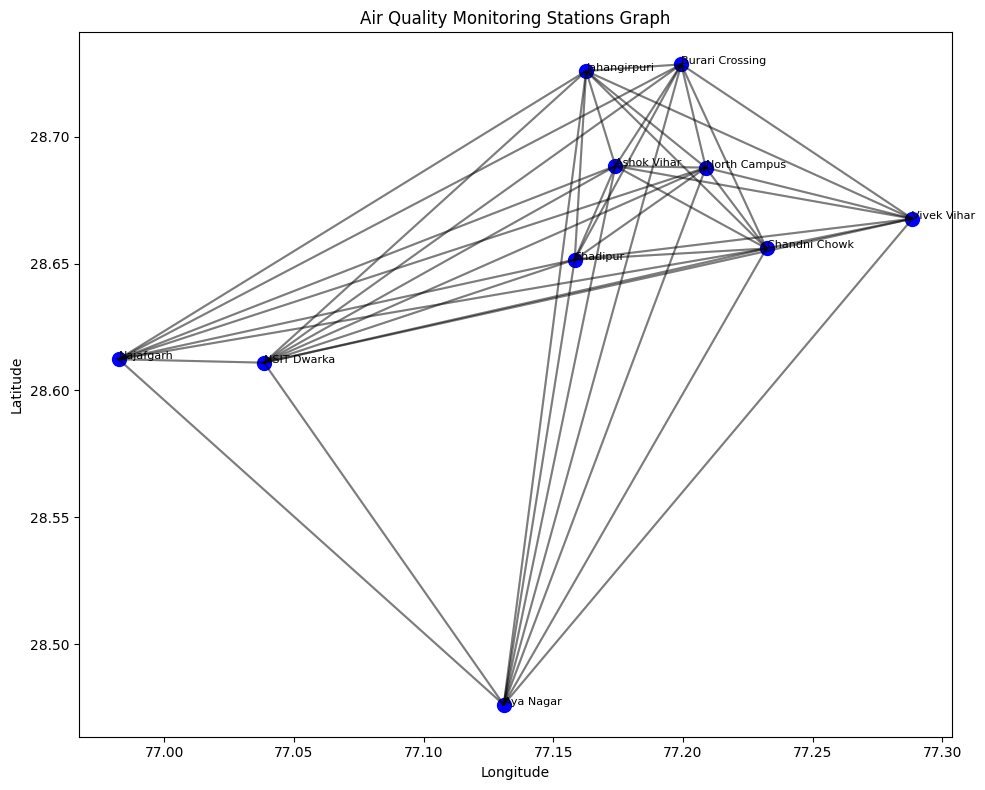

Training GNN and generating embeddings...
Found 10 unique monitoring stations
Created 20819 valid graphs
Starting training for 200 epochs...
Model parameters: 300,856


/miniconda3/envs/gnns/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200, Train Loss: 1.3431, Val Loss: 1.5562, LR: 0.000300
New best model saved with validation loss: 1.5562
Epoch 2/200, Train Loss: 1.1981, Val Loss: 1.5222, LR: 0.000300
New best model saved with validation loss: 1.5222
Epoch 3/200, Train Loss: 1.1754, Val Loss: 1.6117, LR: 0.000300
No improvement, patience: 1/15
Epoch 4/200, Train Loss: 1.1459, Val Loss: 1.6271, LR: 0.000300
No improvement, patience: 2/15
Epoch 5/200, Train Loss: 1.1255, Val Loss: 1.2688, LR: 0.000300
New best model saved with validation loss: 1.2688
Epoch 6/200, Train Loss: 1.1032, Val Loss: 1.5980, LR: 0.000300
No improvement, patience: 1/15
Epoch 7/200, Train Loss: 1.0770, Val Loss: 1.0128, LR: 0.000300
New best model saved with validation loss: 1.0128
Epoch 8/200, Train Loss: 1.0624, Val Loss: 1.3778, LR: 0.000300
No improvement, patience: 1/15
Epoch 9/200, Train Loss: 1.0486, Val Loss: 1.0282, LR: 0.000300
No improvement, patience: 2/15
Epoch 10/200, Train Loss: 1.0310, Val Loss: 1.1481, LR: 0.000300
No i

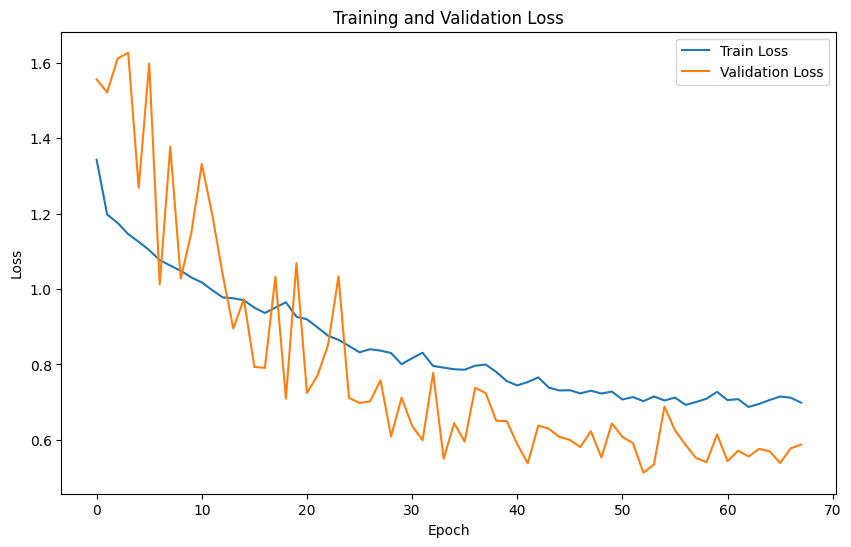

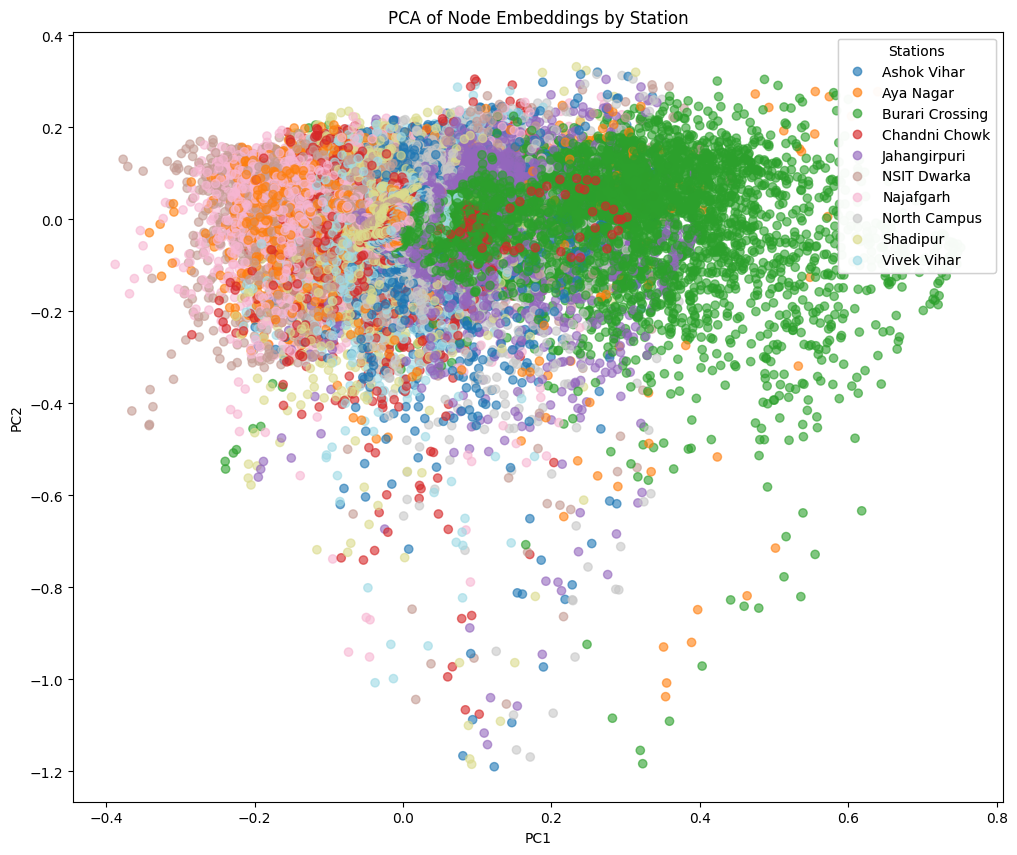

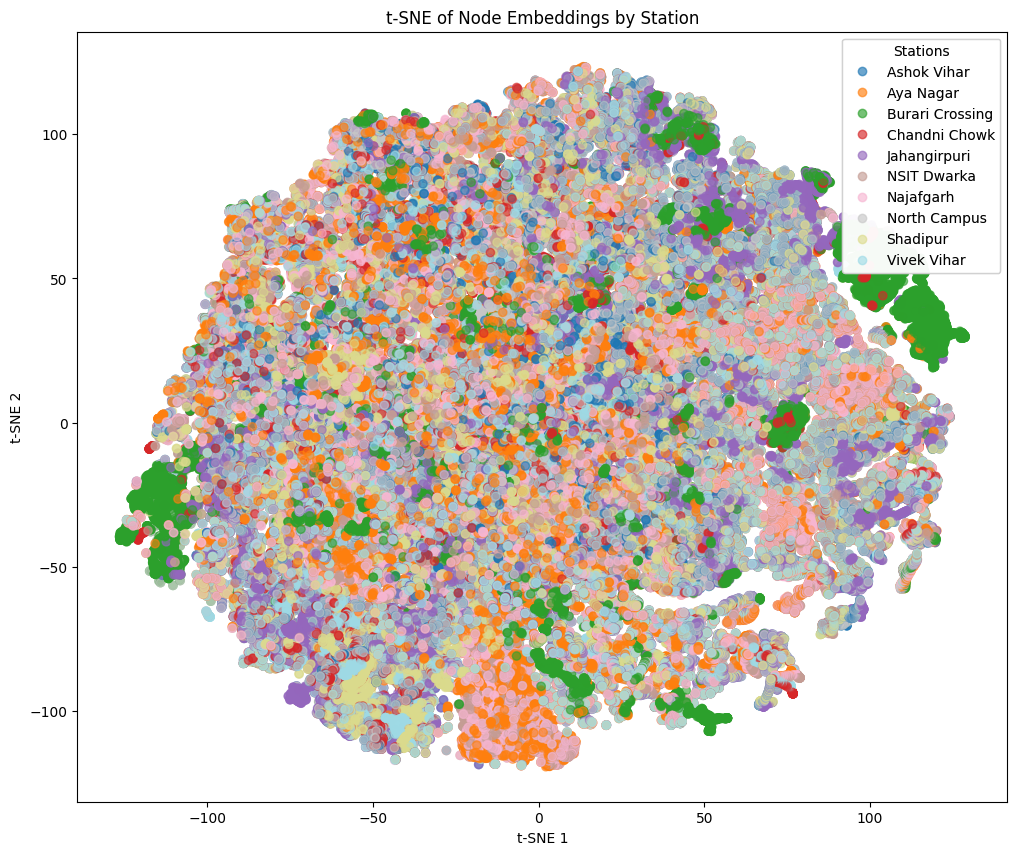

In [5]:
if __name__ == "__main__":
    main()